In [1]:
# install presidio evaluator via pip if not yet installed

#!pip install presidio-evaluator

In [2]:
from pathlib import Path
from pprint import pprint
from collections import Counter
from typing import Dict, List
import json

from presidio_evaluator import InputSample
from presidio_evaluator.evaluation import Evaluator, ModelError, Plotter
from presidio_evaluator.experiment_tracking import get_experiment_tracker

import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

%reload_ext autoreload
%autoreload 2
%matplotlib inline

stanza and spacy_stanza are not installed
Flair is not installed by default


## 1. Load dataset from file

In [3]:
dataset_name = "presidio_data_generator_masked_keys.json" #"synth_dataset_v2.json"
dataset = InputSample.read_dataset_json(Path(Path.cwd().parent, "data", dataset_name))
print(len(dataset))

tokenizing input:   0%|          | 0/2000 [00:00<?, ?it/s]

loading model en_core_web_sm


tokenizing input: 100%|██████████| 2000/2000 [00:10<00:00, 186.27it/s]

2000


This dataset was auto generated. See more info here [Synthetic data generation](1_Generate_data.ipynb).

In [4]:
def get_entity_counts(dataset: List[InputSample]) -> Dict:
    """Return a dictionary with counter per entity type."""
    entity_counter = Counter()
    for sample in dataset:
        for tag in sample.tags:
            entity_counter[tag] += 1
    return entity_counter


## 2. Simple dataset statistics

In [5]:
entity_counts = get_entity_counts(dataset)
print("Count per entity:")
pprint(entity_counts.most_common(), compact=True)

print("\nMin and max number of tokens in dataset: "\
f"Min: {min([len(sample.tokens) for sample in dataset])}, "\
f"Max: {max([len(sample.tokens) for sample in dataset])}")

print(f"Min and max sentence length in dataset: " \
f"Min: {min([len(sample.full_text) for sample in dataset])}, "\
f"Max: {max([len(sample.full_text) for sample in dataset])}")

print("\nExample InputSample:")
print(dataset[0])

Count per entity:
[('O', 25475), ('STREET_ADDRESS', 3856), ('PERSON', 1910),
 ('ORGANIZATION', 1366), ('GPE', 620), ('PHONE_NUMBER', 518),
 ('DATE_TIME', 276), ('CREDIT_CARD', 166), ('TITLE', 144), ('US_SSN', 105),
 ('AGE', 101), ('NRP', 90), ('EMAIL_ADDRESS', 58), ('ZIP_CODE', 48),
 ('DOMAIN_NAME', 37), ('IP_ADDRESS', 25), ('IBAN_CODE', 18),
 ('US_DRIVER_LICENSE', 4)]

Min and max number of tokens in dataset: Min: 2, Max: 79
Min and max sentence length in dataset: Min: 9, Max: 427

Example InputSample:
Full text: The bus station is on Via Pasquale Scura 127
Spans: [Span(type: STREET_ADDRESS, value: Via Pasquale Scura 127, char_span: [22: 44])]



In [6]:
print("A few examples sentences containing each entity:\n")
for entity in entity_counts.keys():
    samples = [sample for sample in dataset if entity in set(sample.tags)]
    if len(samples) > 1 and entity != "O":
        print(f"Entity: <{entity}> two example sentences:\n"
              f"\n1) {samples[0].full_text}"
              f"\n2) {samples[1].full_text}"
              f"\n------------------------------------\n")

A few examples sentences containing each entity:

Entity: <STREET_ADDRESS> two example sentences:

1) The bus station is on Via Pasquale Scura 127
2) Csanád had given Csanád his address: 083 254 Damvergi Street, Nicosia
------------------------------------

Entity: <PERSON> two example sentences:

1) Leigha C Mackay\n\nLa Sagne\nSwitzerland
2) Csanád had given Csanád his address: 083 254 Damvergi Street, Nicosia
------------------------------------

Entity: <GPE> two example sentences:

1) Leigha C Mackay\n\nLa Sagne\nSwitzerland
2) Csanád had given Csanád his address: 083 254 Damvergi Street, Nicosia
------------------------------------

Entity: <PHONE_NUMBER> two example sentences:

1) Can someone call me on 06-82237745? I have some questions about opening an account.
2) Francesca Freeman\n\n35116 Rua Arapiraca 1943\n Apt. 559\n Teixeira de Freitas\n Brazil 35172\n(73) 4746-3459-Office\,781-618-4959-Fax
------------------------------------

Entity: <CREDIT_CARD> two example sentences

## 3. Define the AnalyzerEngine object
Using Presidio with default parameters (not recommended, it's used here for simplicity). For an example on customization, see [notebook 5](5_Evaluate_Custom_Presidio_Analyzer.ipynb)

## 4. Align the dataset's entities to Presidio's entities

There is possibly a difference between the names of entities in the dataset, and the names of entities Presidio can detect.
For example, it could be that a dataset labels a name as PER while Presidio returns PERSON. To be able to compare the predicted value to the actual and gather metrics, an alignment between the entity names is necessary. Consider changing the mapping if your dataset and/or Presidio instance supports difference entity types.

In [7]:
from presidio_evaluator.models import  PresidioAnalyzerWrapper

entities_mapping=PresidioAnalyzerWrapper.presidio_entities_map # default mapping

print("Using this mapping between the dataset and Presidio's entities:")
pprint(entities_mapping, compact=True)


dataset = Evaluator.align_entity_types(
    dataset, 
    entities_mapping=entities_mapping, 
    allow_missing_mappings=True
)
new_entity_counts = get_entity_counts(dataset)
print("\nCount per entity after alignment:")
pprint(new_entity_counts.most_common(), compact=True)

dataset_entities = list(new_entity_counts.values())


Using this mapping between the dataset and Presidio's entities:
{'ADDRESS': 'LOCATION',
 'AGE': 'AGE',
 'BIRTHDAY': 'DATE_TIME',
 'CITY': 'LOCATION',
 'CREDIT_CARD': 'CREDIT_CARD',
 'CREDIT_CARD_NUMBER': 'CREDIT_CARD',
 'DATE': 'DATE_TIME',
 'DATE_OF_BIRTH': 'DATE_TIME',
 'DATE_TIME': 'DATE_TIME',
 'DOB': 'DATE_TIME',
 'DOMAIN': 'URL',
 'DOMAIN_NAME': 'URL',
 'EMAIL': 'EMAIL_ADDRESS',
 'EMAIL_ADDRESS': 'EMAIL_ADDRESS',
 'FACILITY': 'LOCATION',
 'FIRST_NAME': 'PERSON',
 'GPE': 'LOCATION',
 'HCW': 'PERSON',
 'HOSP': 'ORGANIZATION',
 'HOSPITAL': 'ORGANIZATION',
 'IBAN': 'IBAN_CODE',
 'IBAN_CODE': 'IBAN_CODE',
 'ID': 'ID',
 'IP_ADDRESS': 'IP_ADDRESS',
 'LAST_NAME': 'PERSON',
 'LOC': 'LOCATION',
 'LOCATION': 'LOCATION',
 'NAME': 'PERSON',
 'NATIONALITY': 'NRP',
 'NORP': 'NRP',
 'NRP': 'NRP',
 'O': 'O',
 'ORG': 'ORGANIZATION',
 'ORGANIZATION': 'ORGANIZATION',
 'PATIENT': 'PERSON',
 'PATORG': 'ORGANIZATION',
 'PER': 'PERSON',
 'PERSON': 'PERSON',
 'PHONE': 'PHONE_NUMBER',
 'PHONE_NUMBER': 'PH

## 4. Create an AnalyzerEngine object for different thresholds and run the evaluator on that engine
Using Presidio with default parameters (not recommended, it's used here for simplicity). For an example on customization, see [notebook 5](5_Evaluate_Custom_Presidio_Analyzer.ipynb)

In [ ]:
from presidio_analyzer import AnalyzerEngine
from presidio_analyzer.nlp_engine import SpacyNlpEngine, NerModelConfiguration

# Define which model to use
model_config = [{"lang_code": "en", "model_name": "en_core_web_lg"}]

results_per_threshold = dict.fromkeys([0.3, 0.4, 0.45, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9])
#{0.3:None, 0.4: None, 0.45:None, 0.50:None, 0.6: None, 0.65:None, 0.7: None, 0.75:None, 0.8:None, 0.85: None, 0.9: None}
count=1
for threshold in results_per_threshold.keys():
    ner_model_configuration = NerModelConfiguration(default_score = 0.4)

    # Create the NLP Engine based on this configuration
    spacy_nlp_engine = SpacyNlpEngine(models= model_config, ner_model_configuration=ner_model_configuration)
    analyzer_engine = AnalyzerEngine(default_score_threshold=threshold, nlp_engine=spacy_nlp_engine)
    if count == 1:
        pprint(f"Supported entities for English:")
        pprint(analyzer_engine.get_supported_entities("en"), compact=True)

        print(f"\nLoaded recognizers for English:")
        pprint([rec.name for rec in analyzer_engine.registry.get_recognizers("en", all_fields=True)], compact=True)

        print(f"\nLoaded NER models:")
        pprint(analyzer_engine.nlp_engine.models)
    count += 1
    # Create the evaluator object
    evaluator = Evaluator(model=analyzer_engine)

    ## Run experiment

    evaluation_results = evaluator.evaluate_all(dataset, score_threshold=threshold)
    results = evaluator.calculate_score(evaluation_results)
    results_per_threshold[threshold] = results



'Supported entities for English:'
['IN_PAN', 'AU_MEDICARE', 'US_SSN', 'CRYPTO', 'NRP', 'PERSON', 'IN_VOTER',
 'MEDICAL_LICENSE', 'US_PASSPORT', 'AU_ABN', 'UK_NINO', 'IBAN_CODE', 'EMAIL',
 'AU_ACN', 'EMAIL_ADDRESS', 'AGE', 'LOCATION', 'IN_AADHAAR', 'SG_NRIC_FIN',
 'PHONE_NUMBER', 'AU_TFN', 'IP_ADDRESS', 'CREDIT_CARD', 'UK_NHS', 'US_ITIN',
 'IN_VEHICLE_REGISTRATION', 'DATE_TIME', 'IN_PASSPORT', 'ID', 'URL',
 'US_BANK_NUMBER', 'US_DRIVER_LICENSE']

Loaded recognizers for English:
['CreditCardRecognizer', 'UsBankRecognizer', 'UsLicenseRecognizer',
 'UsItinRecognizer', 'UsPassportRecognizer', 'UsSsnRecognizer', 'NhsRecognizer',
 'UkNinoRecognizer', 'SgFinRecognizer', 'AuAbnRecognizer', 'AuAcnRecognizer',
 'AuTfnRecognizer', 'AuMedicareRecognizer', 'InPanRecognizer',
 'InAadhaarRecognizer', 'InVehicleRegistrationRecognizer',
 'InPassportRecognizer', 'CryptoRecognizer', 'DateRecognizer',
 'EmailRecognizer', 'IbanRecognizer', 'IpRecognizer',
 'MedicalLicenseRecognizer', 'PhoneRecognizer', 'Url

## 7. Evaluate results

AGE
               model entity  recall  precision  fpr  count  f2_score  \
1  Presidio Analyzer    AGE     0.0        NaN  0.0    101       NaN   

   threshold  
1        0.9  
CREDIT_CARD
               model       entity    recall  precision  fpr  count  f2_score  \
9  Presidio Analyzer  CREDIT_CARD  0.753012        1.0  0.0    166  0.792142   

   threshold  
9        0.9  
DATE_TIME
                model     entity    recall  precision       fpr  count  \
14  Presidio Analyzer  DATE_TIME  0.974638   0.413846  0.011659    276   
13  Presidio Analyzer  DATE_TIME  0.608696   0.994083  0.000030    276   
12  Presidio Analyzer  DATE_TIME  0.608696   0.994083  0.000030    276   
12  Presidio Analyzer  DATE_TIME  0.469231   1.000000  0.000000    260   

    f2_score  threshold  
14  0.766819        0.4  
13  0.659859        0.5  
12  0.659859        0.6  
12  0.524957        0.9  
EMAIL_ADDRESS
               model         entity  recall  precision  fpr  count  f2_score  \
0  Presidio A

Most common false positive tokens:
[('CO.LTD', 17),
 ('Co.', 15),
 ('60s', 14),
 ('Ltd.', 13),
 ('Answer:"Tube', 13),
 ('Snake', 13),
 ('Boogie', 13),
 ('Zombie', 9),
 ('10th', 9),
 ('Sunday', 9)]
---------------
Example sentence with each FP token:
	- Shintarou Hamaguchi of Kudan Inc. is the CEO of the year. ABC Business considered several other influential CEOs for this year's honor, including Adam McDowell of DeepOntoscomy, Trulia's Ty Campbell, Leena Filppula of Photo-Me International plc's, Allison Salmela of THK CO.LTD., and Orchid Pharma Ltd's Erzsok Sinko. (`CO.LTD` pred as URL)
	- Mission Statement: This non-profit founded by radio executives "serves as an advocate for the value of music" and "supports its songwriters, composers and publishers by taking care of an important aspect of their careers – getting paid," according to the TOP CULTURE Co.Ltd. website. They offer blanket music licenses to businesses and organizations that allow them to play nearly 13 million musical wor

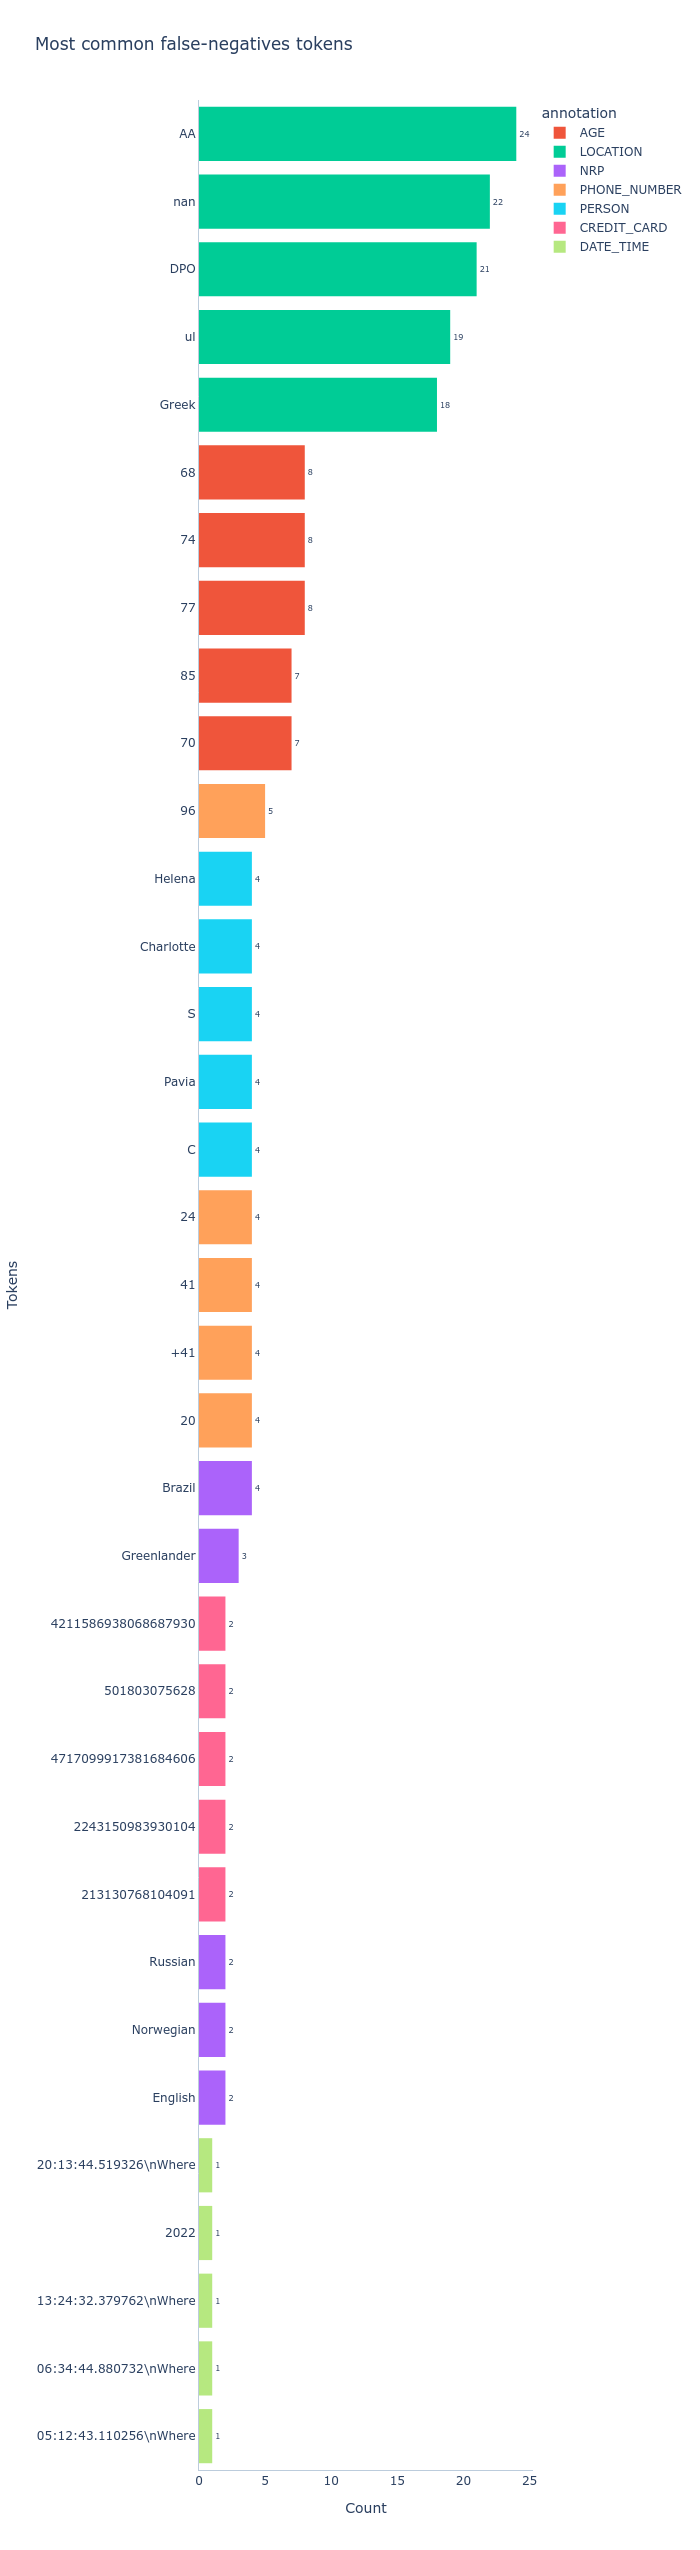

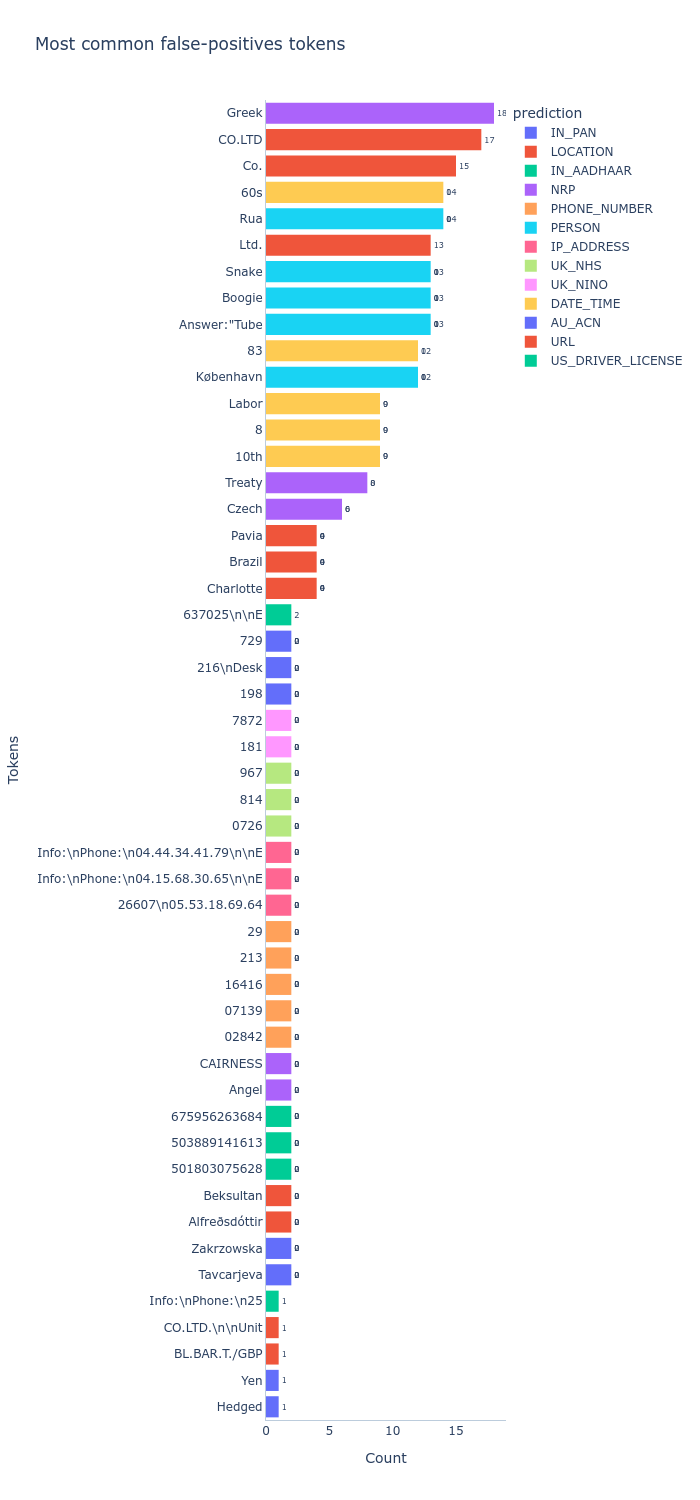

saving experiment data to experiment_20250316-172745.json


Most common false positive tokens:
[('675956263684', 1),
 ('501803075628', 1),
 ('729', 1),
 ('198', 1),
 ('216\\nDesk', 1),
 ('814', 1),
 ('967', 1),
 ('0726', 1),
 ('503889141613', 1)]
---------------
Example sentence with each FP token:
	- Could you please send me the last billed amount for cc 675956263684 on my e-mail PalffyMartuska@rhyta.com? (`675956263684` pred as IN_AADHAAR)
	- I want to cancel my card 501803075628 because I lost it (`501803075628` pred as IN_AADHAAR)
	- Vitór Gomes\nAvista Public Acquisition Corp. II Unit\nUnit 1324 Box 7546
DPO AP 85115\nMobile: 729 198 216\nDesk: 07700 373 678\nFax: +41 80 821 48 62\n (`729` pred as AU_ACN)
	- Vitór Gomes\nAvista Public Acquisition Corp. II Unit\nUnit 1324 Box 7546
DPO AP 85115\nMobile: 729 198 216\nDesk: 07700 373 678\nFax: +41 80 821 48 62\n (`198` pred as AU_ACN)
	- Vitór Gomes\nAvista Public Acquisition Corp. II Unit\nUnit 1324 Box 7546
DPO AP 85115\nMobile: 729 198 216\nDesk: 07700 373 678\nFax: +41 80 821 48 62\n (`216

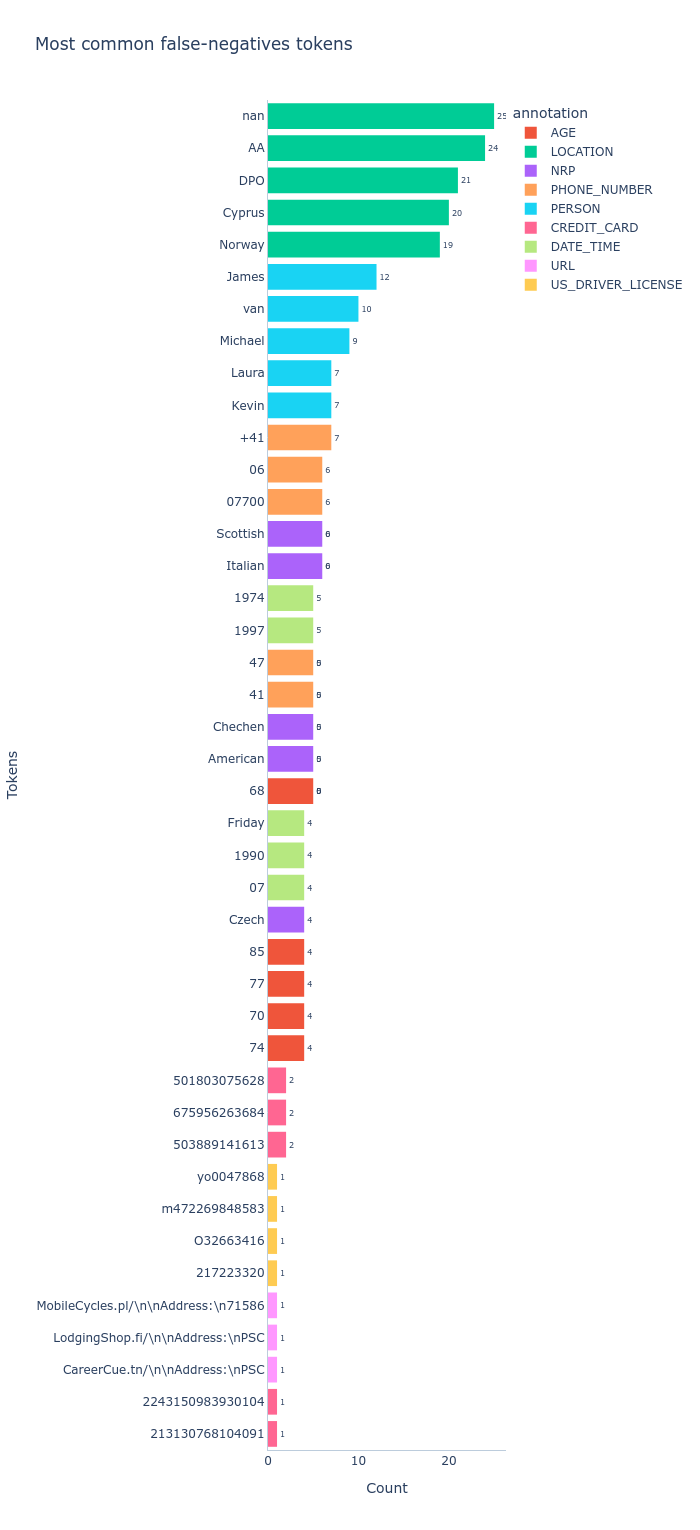

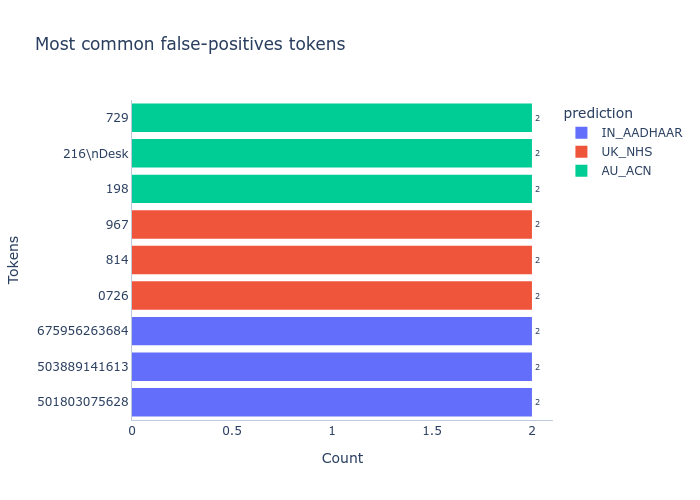

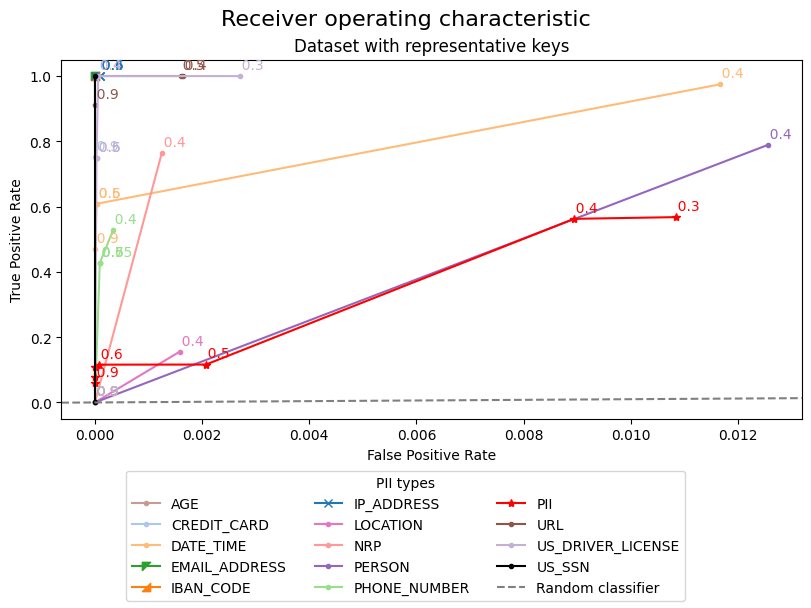

In [13]:
from presidio_evaluator.evaluation.plot_multiple_eval_results import PlotterForMultipleEvaluations

plotter = PlotterForMultipleEvaluations(dataset_name, results_per_threshold)
plotter.process_multiple_evaluators()



## 8. Error analysis

Now let's look into results to understand what's behind the metrics we're getting.
Note that evaluation is never perfect. Some things to consider:
1. There's often a mismatch between the annotated span and the predicted span, which isn't necessarily a mistake. For example: `<Southern France>` compared with `Southern <France>`. In the second text, the word `Southern` was not annotated/predicted as part of the entity, but that's not necessarily an error.
2. Token based evaluation (which is used here) counts the number of true positive / false positive / false negative tokens. Some entities might be broken into more tokens than others. For example, the phone number `222-444-1234` could be broken into five different tokens, whereas `Krishna` would be broken into one token, resulting in phone numbers having more influence on metrics than names.
3. The synthetic dataset used here isn't representative of a real dataset. Consider using more realistic datasets for evaluation